## Exercises 4

## Data Extraction
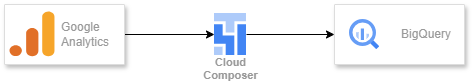 <br>

#### Authentication and Access
To extract data from the Google Analytics API, we'll need to set up authentication and authorize the application: <br>
##### Google Cloud Platform Setup:
- Create a new project in Google Cloud Platform (GCP).
- Enable the Google Analytics API.
- Create OAuth 2.0 credentials to get a client ID and client secret.
##### Service Account:
- Create a service account in GCP. <br>
- Grant the service account access to the Google Analytics view. <br>
- Download the JSON key file for the service account. <br>
<br>
## Data Pipeline
To automate the execution of the ETL we’ll use Google Cloud Composer so that it runs weekly, we’ll follow these steps: <br>
- ##### Configure Cloud Composer: 
We need to have the Google Cloud Composer environment set up. <br>


- ##### Create the DAG (Directed Acyclic Graph) in Airflow:
Create a DAG that runs weekly to pull data from Google Analytics and load it into BigQuery. <br>

#### DAG to Run the ETL Weekly
First, we need to create a Python file to define the DAG in the Cloud Composer environment. <br>
File path in Cloud Composer:<br>
##### /home/airflow/gcs/dags/etl_google_analytics_to_bigquery.py

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/etl_google_analytics_to_bigquery.py">Link to etl_google_analytics_to_bigquery.py</a>


In [ ]:
# etl_google_analytics_to_bigquery.py
from airflow import DAG
from airflow.utils.dates import days_ago
from airflow.operators.python_operator import PythonOperator
from airflow.providers.google.cloud.operators.bigquery import BigQueryCreateEmptyTableOperator, BigQueryInsertJobOperator
from google.oauth2 import service_account
from googleapiclient.discovery import build
from google.cloud import bigquery
from datetime import datetime, timedelta

# Define default arguments
default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
}

# Define the DAG
dag = DAG(
    'etl_google_analytics_to_bigquery',
    default_args=default_args,
    description='ETL pipeline for Google Analytics to BigQuery',
    schedule_interval='@weekly',  # Run once a week
    start_date=days_ago(1),
    catchup=False,
)

# Function to create the table in BigQuery if it doesn't exist
def create_table():
    client = bigquery.Client()
    table_id = 'weekly_analytics_report',
    dataset_id='analytics-report'
    task_id='create_table',
    project_id = 'demo-dbt-project',
    schema = [
        bigquery.SchemaField("week_start_date", "DATE"),
        bigquery.SchemaField("sessions", "INTEGER"),
        bigquery.SchemaField("pageviews", "INTEGER"),
        bigquery.SchemaField("users", "INTEGER"),
        bigquery.SchemaField("bounce_rate", "FLOAT"),
        bigquery.SchemaField("conversion_rate", "FLOAT"),
        bigquery.SchemaField("average_session_duration", "FLOAT"),
        bigquery.SchemaField("devices", "STRING"),
        bigquery.SchemaField("country", "STRING"),
        bigquery.SchemaField("postal_co", "STRING"),
        bigquery.SchemaField("campaign", "STRING"),
        bigquery.SchemaField("campaign_id", "STRING"),
    ]

    table = bigquery.Table(table_id, schema=schema)

    try:
        client.get_table(table_id)
        print(f"Table {table_id} already exists.")
    except Exception:
        table = client.create_table(table)
        print(f"Created table {table.project_id}.{table.dataset_id}.{table.table_id}")

# Function to extract data from Google Analytics and load to BigQuery
def extract_load():
    SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
    SERVICE_ACCOUNT_FILE = '/path/to/service-account-file.json'
    credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    
    # Initialize Analytics Reporting API
    analytics = build('analyticsreporting', 'v4', credentials=credentials)

    # Define the date range (last 7 days)
    date_range = {
        'startDate': '7daysAgo',
        'endDate': 'yesterday'
    }

    # Define the metrics and dimensions
    metrics = [
        {'expression': 'ga:sessions'},
        {'expression': 'ga:pageviews'},
        {'expression': 'ga:users'},
        {'expression': 'ga:bounceRate'},
        {'expression': 'ga:conversionRate'},
        {'expression': 'ga:average_session_duration'}
    ]
    dimensions = [
        {'name': 'ga:date'},
        {'name': 'ga:devices'},
        {'name': 'ga:country'}
        {'name': 'ga:postal_co'}
        {'name': 'ga:campaign'}
        {'name': 'ga:campaign_id'}
    ]

    # Make the API request
    request = analytics.reports().batchGet(
        body={
            'reportRequests': [
                {
                    'viewId': 'YOUR_VIEW_ID',
                    'dateRanges': [date_range],
                    'metrics': metrics,
                    'dimensions': dimensions
                }]
        }
    ).execute()

    # Process the request and transform data for BigQuery
    rows = []
    for report in request.get('reports', []):
        for row in report.get('data', {}).get('rows', []):
            date = row.get('dimensions', [])[0]
            devices = row.get('dimensions', [])[1]
            country = row.get('dimensions', [])[2]
            postal_co = row.get('dimensions', [])[3]
            campaign = row.get('dimensions', [])[4]
            campaign_id = row.get('dimensions', [])[5]
            metrics_data = row.get('metrics', [])[0].get('values', [])
            rows.append({
                'week_start_date': date,
                'sessions': int(metrics_data[0]),
                'pageviews': int(metrics_data[1]),
                'users': int(metrics_data[2]),
                'bounce_rate': float(metrics_data[3]),
                'conversion_rate': float(metrics_data[4]),
                'devices': devices,
                'country': country,
                'postal_co': postal_co,
                'campaign': campaign,
                'campaign_id': campaign_id,
                'average_session_duration': float(metrics_data[5])
            })

    # Load data into BigQuery
    client = bigquery.Client()
    table_id = 'weekly_analytics_report'
    errors = client.insert_rows_json(table_id, rows)

    if errors:
        print(f'Encountered errors while inserting rows: {errors}')
    else:
        print('Rows successfully inserted.')

# Define the PythonOperator to create the table
create_table_op = PythonOperator(
    task_id='create_table',
    python_callable=create_table,
    dag=dag,
)

# Define the PythonOperator to run the extract_load function
run_etl = PythonOperator(
    task_id='run_etl',
    python_callable=extract_load,
    dag=dag,
)
# Task dependencies
create_table_op >> run_etl

#### Cloud Composer’s implementation
- ##### Upload the file to the DAG directory:
Upload etl_google_analytics_to_bigquery.py to the Cloud Storage bucket associated with your Cloud Composer environment.

- ##### Verify the DAG in the Airflow UI:
Verify that the etl_google_analytics_to_bigquery DAG is listed and enabled.

- ##### Run and monitor the DAG:
Monitors the execution of the DAG to verify that data is correctly extracted and loaded into BigQuery.


## Data Modeling
Table to store the etl_google_analytics_to_bigquery <br>
<br>

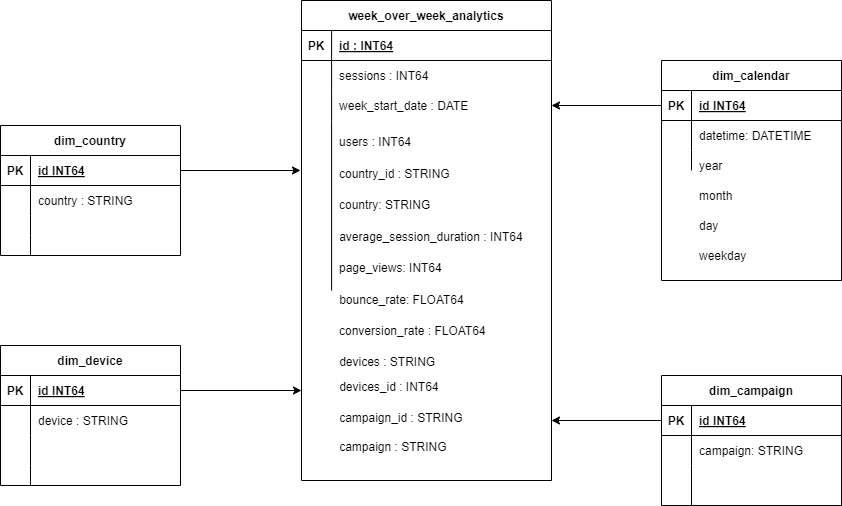

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/weekly_analytics_report.sql">Link to Create Table Query: weekly_analytics_report.sql</a>

In [ ]:
CREATE OR REPLACE TABLE `demo-dbt-project.analytics-report.weekly_analytics_report` (
    week_start_date DATE OPTIONS(description="The starting date of the week")
    ,sessions INT64 OPTIONS(description="Total number of sessions")
    ,pageviews INT64 OPTIONS(description="Total number of pageviews")
    ,users INT64 OPTIONS(description="Total number of unique users")
    ,bounce_rate FLOAT64 OPTIONS(description="Percentage of single-page sessions")
    ,conversion_rate FLOAT64 OPTIONS(description="Rate of goal conversions")
    ,devices STRING OPTIONS(description="Types of devices used by users")
    ,country STRING OPTIONS(description="Geographical location of users")
    ,postal_co STRING OPTIONS(description="Postal Code")
    ,campaign STRING OPTIONS(description="Campaign Name")
    ,campaign_id STRING OPTIONS(description="Campaign ID")
    ,average_session_duration FLOAT64 OPTIONS(description="Average duration of sessions in seconds")
);

# Table with calcultaed metrics (calculadas en dbt Data Model)
CREATE OR REPLACE TABLE `demo-dbt-project.analytics-report.week_over_week_analytics` (
    week_start_date DATE OPTIONS(description="The starting date of the week")
    ,sessions INT64 OPTIONS(description="Total number of sessions")
    ,pageviews INT64 OPTIONS(description="Total number of pageviews")
    ,users INT64 OPTIONS(description="Total number of unique users")
    ,bounce_rate FLOAT64 OPTIONS(description="Percentage of single-page sessions")
    ,conversion_rate FLOAT64 OPTIONS(description="Rate of goal conversions")
    ,average_session_duration FLOAT64 OPTIONS(description="Average duration of sessions in seconds")
    ,devices STRING OPTIONS(description="Types of devices used by users")
    ,devices_id STRING OPTIONS(description="Types of devices used by users")
    ,country STRING OPTIONS(description="Geographical location of users")
    ,country_id STRING OPTIONS(description="Geographical location of users")
    ,postal_co STRING OPTIONS(description="Postal Code")
    ,campaign STRING OPTIONS(description="Campaign Name")
    ,campaign_id STRING OPTIONS(description="Campaign ID")
    ,prev_sessions FLOAT64 OPTIONS(description="")
    ,prev_pageviews FLOAT64 OPTIONS(description="")
    ,prev_users FLOAT64 OPTIONS(description="")
    ,prev_bounce_rate FLOAT64 OPTIONS(description="")
    ,prev_avg_session_duration FLOAT64 OPTIONS(description="")
    ,pct_change_sessions FLOAT64 OPTIONS(description="")
    ,pct_change_pageviews FLOAT64 OPTIONS(description="")
    ,pct_change_users FLOAT64 OPTIONS(description="")
    ,pct_change_bounce_rate FLOAT64 OPTIONS(description="")
    ,pct_change_conversion_rate FLOAT64 OPTIONS(description="")
    ,pct_change_avg_session_duration FLOAT64 OPTIONS(description="")
);



### Using dbt for Data Modeling
We'll use DBT for data modeling and automating the data transformation process. <br> 
We need to define dbt models to handle the extraction and transformation of data, and then calculate the week-over-week metrics. <br>

We create an staging, intermediate and final model.

### Staging Model

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/week_over_week_analytics_stg.sql">Link to Staging Model: week_over_week_analytics_stg.sql</a>

In [ ]:
{{ config(
    materialized = 'view'
) }}

WITH source AS (

    SELECT
        week_start_date,
        sessions,
        pageviews,
        users,
        bounce_rate,
        conversion_rate,
        average_session_duration,
        devices,
        country,
        postal_co,
        campaign,
        campaign_id
    FROM
        {{ source('analytics-report', 'weekly_analytics_report') }}
)
SELECT
    week_start_date,
    sessions,
    pageviews,
    users,
    bounce_rate,
    conversion_rate,
    average_session_duration,
    devices,
    country,
    postal_co,
    campaign,
    campaign_id
FROM
    source


### Intermediate Model

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/week_over_week_analytics_int.sql">Link to Intermediate Model: week_over_week_analytics_int.sql</a>

In [ ]:
{{ config(
    materialized = 'view'
) }}

WITH weekly_data AS (

    SELECT
        week_start_date as datetime_id,
        SUM(sessions) AS sessions,
        SUM(pageviews) AS pageviews,
        SUM(users) AS users,
        AVG(bounce_rate) AS bounce_rate,
        AVG(conversion_rate) AS conversion_rate,
        AVG(average_session_duration) AS average_session_duration,
        devices,
        country,
        postal_co,
        {{ dbt_utils.generate_surrogate_key(['country', 'postal_co']) }} as country_id,
        campaign,
        campaign_id
    FROM
        {{ ref('week_over_week_analytics_stg') }}
    GROUP BY
        week_start_date
)
SELECT
    dt.datetime_id as week_start_date,
    sessions,
    pageviews,
    users,
    bounce_rate,
    conversion_rate,
    average_session_duration,
    devices,
    dd.devices_id,
    country,
    dc.country_id,
    postal_co,
    campaign,
    dcamp.campaign_id
FROM
    weekly_data week
INNER JOIN {{ ref('dim_datetime') }} dt ON week.datetime_id = dt.datetime_id
INNER JOIN {{ ref('dim_country') }} dc ON week.country_id = dc.country_id
INNER JOIN {{ ref('dim_devices') }} dd ON week.devices = dd.devices
INNER JOIN {{ ref('dim_campaign') }} dcamp ON week.campaign_id = dcamp.campaign_id;


### Final Model for Week-over-Week Metrics

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/week_over_week_analytics.sql">Link to Final Model: week_over_week_analytics.sql</a>

In [ ]:
{{ config(
    materialized='table'
) }}

WITH weekly_data_lag AS (
    SELECT
        week_start_date,
        sessions,
        pageviews,
        users,
        bounce_rate,
        conversion_rate,
        average_session_duration,
        LAG(sessions) OVER (ORDER BY week_start_date) AS prev_sessions,
        LAG(pageviews) OVER (ORDER BY week_start_date) AS prev_pageviews,
        LAG(users) OVER (ORDER BY week_start_date) AS prev_users,
        LAG(bounce_rate) OVER (ORDER BY week_start_date) AS prev_bounce_rate,
        LAG(conversion_rate) OVER (ORDER BY week_start_date) AS prev_conversion_rate,
        LAG(average_session_duration) OVER (ORDER BY week_start_date) AS prev_avg_session_duration
        devices,
        devices_id,
        country,
        country_id,
        postal_co,
        campaign,
        campaign_id
        FROM
            {{ ref('week_over_week_analytics_int') }}
)

SELECT
    week_start_date,
    sessions,
    pageviews,
    users,
    bounce_rate,
    conversion_rate,
    average_session_duration,
    prev_sessions,
    prev_pageviews,
    prev_users,
    prev_bounce_rate,
    prev_conversion_rate,
    prev_avg_session_duration,
    SAFE_DIVIDE(sessions - prev_sessions, prev_sessions) * 100 AS pct_change_sessions,
    SAFE_DIVIDE(pageviews - prev_pageviews, prev_pageviews) * 100 AS pct_change_pageviews,
    SAFE_DIVIDE(users - prev_users, prev_users) * 100 AS pct_change_users,
    SAFE_DIVIDE(bounce_rate - prev_bounce_rate, prev_bounce_rate) * 100 AS pct_change_bounce_rate,
    SAFE_DIVIDE(conversion_rate - prev_conversion_rate, prev_conversion_rate) * 100 AS pct_change_conversion_rate,
    SAFE_DIVIDE(average_session_duration - prev_avg_session_duration, prev_avg_session_duration) * 100 AS pct_change_avg_session_duration
    devices,
    devices_id,
    country,
    country_id,
    postal_co,
    campaign,
    campaign_id
FROM
    weekly_data_lag
ORDER BY
    week_start_date;


#### Then we create Dimesions: dim_devices, dim_country, dim_campaign and dim_calendar

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/dim_device.sql">Link to dim_devices</a>

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/dim_campaign.sql">Link to dim_campaign</a>

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/dim_country.sql">Link to dim_country</a>

<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/dim_calendar.sql">Link to dim_calendar</a>
<br>

In [ ]:
# Dim Devices
WITH device AS (
 SELECT DISTINCT
    GENERATE_UUID() as devices_id
    ,devices AS devices
 FROM 
    {{ source('analytics', 'weekly_analytics_report') }}
 WHERE 
    devices IS NOT NULL
)
SELECT
    devices_id
    ,devices
FROM 
    device d;

# Dim Country
WITH country AS (
 SELECT DISTINCT
    {{ dbt_utils.generate_surrogate_key(['country', 'postal_co']) }} as country_id
    ,country AS country
 FROM 
    {{ source('analytics', 'weekly_analytics_report') }}
 WHERE 
    country IS NOT NULL
)
SELECT
    country_id
    ,country
FROM 
    country c;

# Dim Campaign
WITH campaign AS (
 SELECT DISTINCT
    campaign_id
    ,campaign AS campaign
 FROM 
    {{ source('analytics', 'weekly_analytics_report') }}
 WHERE 
    campaign IS NOT NULL
)
SELECT
    camp.campaign_id
    ,camp.campaign
FROM 
    campaign camp;

# Dim Calendar
WITH datetime AS ( 
 SELECT DISTINCT
 week_start_date AS datetime_id,
 CASE
 WHEN LENGTH(week_start_date) = 16 THEN
 - Date format: "DD/MM/YYYY HH:MM"
 PARSE_DATETIME('%m/%d/%Y %H:%M', week_start_date)
 WHEN LENGTH(week_start_date) <= 14 THEN
 - Date format: "MM/DD/YY HH:MM"
 PARSE_DATETIME('%m/%d/%y %H:%M', week_start_date)
 ELSE
 NULL
 END AS date_part
 FROM 
    {{ source('analytics', 'weekly_analytics_report') }}
 WHERE week_start_date IS NOT NULL
)
SELECT
 datetime_id,
 date_part as datetime,
 EXTRACT(YEAR FROM date_part) AS year,
 EXTRACT(MONTH FROM date_part) AS month,
 EXTRACT(DAY FROM date_part) AS day,
 EXTRACT(DAYOFWEEK FROM date_part) AS weekday
FROM datetime;

#### For this we need to set up the profiles.yml file with BigQuery configuration:

In [ ]:
demo_dbt_proyect:
  outputs:
    dev:
      dataset: analytics-report
      job_execution_timeout_seconds: 600
      job_retries: 1
      location: US
      method: oauth
      priority: interactive
      project: demo-dbt-project
      threads: 2
      type: bigquery
  target: dev

#### And configure the schema.yml as follow:
<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/schema.yml">Link to schema.yml</a>

In [ ]:
version: 2

models:
  - name: week_over_week_analytics_stg
    description: "Week Analytics Stage"
    columns:
      - name: sessions
        description: ""

      - name: week_start_date
        description: ""

      - name: average_session_duration
        description: ""

      - name: pageviews
        description: ""

      - name: users
        description: ""

      - name: bounce_rate
        description: ""

      - name: conversion_rate
        description: ""

      - name: devices
        description: ""

      - name: country
        description: ""

      - name: postal_co
        description: ""

      - name: campaign
        description: ""

      - name: campaign_id
        description: ""

  - name: week_over_week_analytics_int
    description: "Week Analytics Intermediate"
    columns:
      - name: sessions
        description: ""

      - name: week_start_date
        description: ""

      - name: average_session_duration
        description: ""

      - name: pageviews
        description: ""

      - name: users
        description: ""

      - name: bounce_rate
        description: ""

      - name: conversion_rate
        description: ""

      - name: devices
        description: ""

      - name: devices_id
        description: ""

      - name: country_id
        description: ""

      - name: country
        description: ""

      - name: postal_co
        description: ""

      - name: campaign
        description: ""

      - name: campaign_id
        description: ""

  - name: week_over_week_analytics
    description: "Week Analytics Final Table"
    columns:
      - name: sessions
        description: ""

      - name: week_start_date
        description: ""

      - name: average_session_duration
        description: ""

      - name: pageviews
        description: ""

      - name: users
        description: ""

      - name: bounce_rate
        description: ""

      - name: conversion_rate
        description: ""

      - name: devices
        description: ""

      - name: devices_id
        description: ""

      - name: country_id
        description: ""

      - name: country
        description: ""

      - name: postal_co
        description: ""

      - name: campaign
        description: ""

      - name: campaign_id
        description: ""

      - name: prev_sessions
        description: ""

      - name: prev_pageviews
        description: ""

      - name: prev_users
        description: ""

      - name: prev_bounce_rate
        description: ""

      - name: prev_conversion_rate
        description: ""

      - name: prev_avg_session_duration
        description: ""

      - name: pct_change_sessions
        description: ""

      - name: pct_change_pageviews
        description: ""

      - name: pct_change_users
        description: ""

      - name: pct_change_bounce_rate
        description: ""

      - name: pct_change_conversion_rate
        description: ""

      - name: pct_change_avg_session_duration
        description: ""


#### And configure de source.yml
<a href = "https://github.com/katerinneramos/data-engineer-technical-test/blob/main/4TechnicalTest/demo-dbt-proyect/demo_dbt_proyect/models/source.yml">Link to source.yml</a>

In [ ]:
version: 2

sources:
  - name: analytics
    tables:
      - name: weekly_analytics_report


#### Finally, run the dbt commands

In [ ]:
dbt run